In [65]:
%reload_ext autoreload
%autoreload 2

In [66]:
import sys
sys.path.append('..')
import numpy as np
from numpy.random import random as rand

import networkqit as nq
import networkx as nx

from networkqit import graph_laplacian as GL

import scipy.optimize
import scipy.linalg

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sympy as sp
import sympyprinting as spp
from sympy import init_printing

import mpmath as mp
import networkx as nx

#### 1. Define the Stieltjes transform $t_r(z)$ as in Peixoto 2013, Spectra of random modular graphs and the symbols

In [67]:
n_=sp.Symbol('n',integer=True)
pin_=sp.Symbol('pin',real=True)
pout_=sp.Symbol('pout',real=True)
a_=sp.Symbol('a',real=True)
d_=sp.Symbol('d',real=True)
c_=sp.Symbol('c',integer=True)
z_=sp.Symbol('z',complex=True)
b_=sp.Symbol('b',integer=True)
t_=sp.Symbol('t',complex=True)

# this is the average degree in the planted partition model with B blocks and n nodes
def avg_deg_planted(n,b,pin,pout):
    return pin * n / b + (b-1) * pout * n / b

def poisspdf(k,l):
    return sp.exp(-l)*(l**k)/sp.gamma(k+1)

def adj_fundamental_eq(n,b,pin,pout,t,z):
    sum_sigma2rs_ns_ts = (n/b)*(pin*t_ + pout*t_)
    return  (t_ - sp.summation(sp.KroneckerDelta(c_,0)/(z_-c_-sum_sigma2rs_ns_ts),(c_,0,sp.oo)))

def adj_fundamental_eq2(a,d,t,z):
    return  (t_ - sp.summation(sp.KroneckerDelta(c_,d_)/(z_-c_-a*t_),(c_,0,sp.oo)))

def lapl_fundamental_eq(n,b,pin,pout,t,z):
    d = (n-1) / b * (pin+pout) # average within module degree
    sum_sigma2rs_ns_ts = (n/b)*(pin*t_ + pout*t_)
    return  (t_ - sp.summation(poisspdf(c_,d)/(z_-c_-sum_sigma2rs_ns_ts),(c_,0,sp.oo)))

def lapl_fundamental_eq2(a,d,t,z):   
    return  (t_ - sp.summation(poisspdf(c_,d)/(z_-c_-a*t_),(c_,0,sp.oo)))

adj_feq = sp.lambdify((n_,b_,pin_,pout_,t_,z_),adj_fundamental_eq(n_,b_,pin_,pout_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
adj_feq2 = sp.lambdify((a_,d_,t_,z_),adj_fundamental_eq2(a_,d_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
lapl_feq = sp.lambdify((n_,b_,pin_,pout_,t_,z_),lapl_fundamental_eq(n_,b_,pin_,pout_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
lapl_feq2 = sp.lambdify((a_,d_,t_,z_),lapl_fundamental_eq2(a_,d_,t_,z_).replace('exp_polar','exp'), modules='mpmath')

#### 2. Look for the spectrum of the adjacency matrix (planted partition n=50, B=2, pin=0.5,pout=0.5)

In [121]:
init_printing()
b=2
t = sp.symbols('t0:'+str(b),complex=True)
pin=1
pout=0
n=100
sp.solve( (sp.eye(b) - (sp.eye(b)*sp.diag(*t))*((sp.ones(b)-sp.eye(b))*pout + pin*sp.eye(b))*(n/b*sp.eye(b))).det(), t)
#sp.Identity(b_)
#sp.solve((sp.eye(2)-sp.Matrix([[t_,0],[0,t_]])*sp.Matrix([[pin_,pout_],[pout_,pin_]])*(n_/b_)*sp.eye(2)).det(),t_)

In [4]:
def spectral_density(n,b,pin,pout,zmin,zmax,dz, matrix,**kwargs):
    # Solve Eq.2 given z, look for tr
    all_rho = []
    count = 0
    eps = kwargs.get('eps',1E-9)
    tr = [0]*b
    for r in range(0,b):
        # Now solve the equation for t and increasing z in iterative way
        z0 = zmin + eps*1j
        t0 = (np.random.random() + np.random.random()*1j) * 1E-3
        tr[r] = t0
        z = z0        
        nz = int((zmax-zmin)/dz)
        while np.real(z) < zmax:
            print('\r', count/(b*nz)*100.0,'%', '-- ',matrix, end='')
            if matrix is 'laplacian':
                tr[r] = mp.findroot(lambda t: lapl_feq(n,b,pin,pout,t,z), x0 = tr[r], solver='muller') # important to use the "muller" solver
            elif matrix is 'adjacency':
                tr[r] = mp.findroot(lambda t: adj_feq(n,b,pin,pout,t,z),  x0 = tr[r], solver='muller') # important to use the "muller" solver
            else:
                raise 'not supported matrix'
            z += dz
            rhoz = -1/(n*mp.pi)*(n/b*tr[r].imag)
            all_rho.append(rhoz)
            count += 1
    
    for z in np.linspace(zmin,zmax,nz):
        det = sp.ones(b)
        for r in range(0,b):
            det -= 
    # Solve Eq.4 
    ts1 = sp.Symbol('ts1',complex=True)
    ts2 = sp.Symbol('ts2',complex=True)
    det = sp.eye(b) - (sp.eye(b)*sp.diag([ts1,ts2])*sp.Matrix([[pin,pout],[pout,pin]])*sp.Matrix() )
    
    all_rho = np.array(all_rho).flatten()    
    return np.linspace(zmin,zmax,nz), np.reshape(all_rho,[b,nz]).sum(axis=0)

# This version takes a,d parameters
def spectral_density2(a,d,b,zmin,zmax,dz, matrix,**kwargs):
    # Solve Eq.2 given z, look for tr
    all_rho = []
    count = 0
    eps = kwargs.get('eps',1E-9)
    tr = [0]*b
    for r in range(0,b):
        # Now solve the equation for t and increasing z in iterative way
        z0 = zmin + eps*1j
        t0 = (np.random.random() + np.random.random()*1j) * 1E-3
        tr[r] = t0
        z = z0        
        nz = int((zmax-zmin)/dz)
        while np.real(z) < zmax:
            print('\r', count/(b*nz)*100.0,'%', '-- ',matrix, end='')
            if matrix is 'laplacian':
                tr[r] = mp.findroot(lambda t: lapl_feq2(a,d,t,z), x0 = tr[r], solver='muller') # important to use the "muller" solver
            elif matrix is 'adjacency':
                tr[r] = mp.findroot(lambda t: adj_feq2(a,d,t,z),  x0 = tr[r], solver='muller') # important to use the "muller" solver
            else:
                raise 'not supported matrix'
            z += dz
            rhoz = -1/(n*mp.pi)*np.array([n/b*tr[r].imag for r in range(0,b)]).sum()
            all_rho.append(rhoz)
            count += 1

    all_rho = np.array(all_rho).flatten()
    
    return np.linspace(zmin,zmax,nz), np.reshape(all_rho,[b,nz]).sum(axis=0)

#### 3. Verify the results with the corresponding numerical simulation

In [5]:
def planted_partition_graph(n,b,pin,pout):
    nb = int(n/b)
    A = (np.random.random((n,n)) < pout).astype(float)
    for i in range(0,b):
        T = np.triu((np.random.random((nb,nb))<pin).astype(float))
        T = T+T.T
        A[i*nb:(i+1)*nb,i*nb:(i+1)*nb] = T
        
    np.fill_diagonal(A,0)
    A = np.triu(A)
    A = A+A.T
    return A

In [45]:
n, b, pin, pout = 2000, 2, 0.8, 0.8

eigs_l,eigs_a = [], []
for i in range(0,50):
    print('\r',i,end='')
    #A = nx.to_numpy_array(nx.planted_partition_graph(b,int(n/b),pin,pout),dtype=np.float128)
    A = planted_partition_graph(n,b,pin,pout)
    L=np.diag(A.sum(axis=0))-A
    eigs_a.append(scipy.linalg.eigvalsh(A))
    eigs_l.append(scipy.linalg.eigvalsh(L))
eigs_a = np.array(eigs_a).flatten()
eigs_l = np.array(eigs_l).flatten()

 49

In [50]:
dz=0.1
#all_z_adj,rho_adj  = spectral_density(n,b,pin,pout, -40,40, dz,'adjacency',eps=1E-9)
a = (eigs_a.min()/2)**2
print(a)
all_z_adj,rho_adj  = spectral_density2(a, 0, b, -60, 60, dz,'adjacency', eps=1E-9)
#all_z_lapl,rho_lapl  = spectral_density2(a,n*pin,b,3000, 3500,  50,'laplacian',eps=1E-9)

338.56523629534166
 99.95833333333334 % --  adjacency

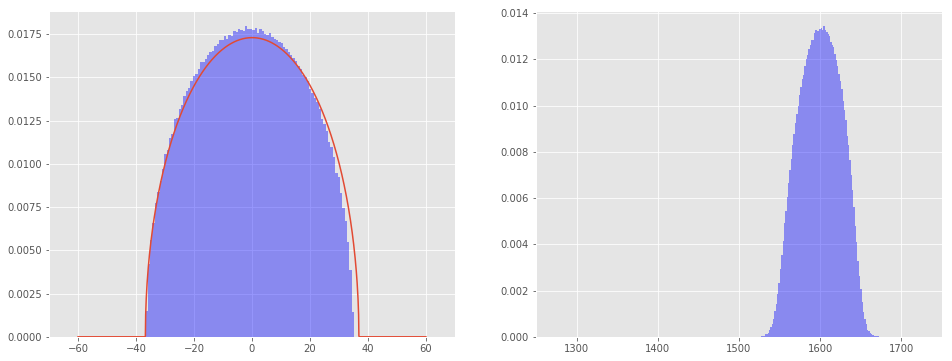

In [52]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))
ax[0].hist(eigs_a,2000,density=True,color='blue',alpha=0.4)
ax[0].plot(all_z_adj,rho_adj)
#ax[0].set_title('Adjacency n=%d B=%d $p_{in}$=%.2f $p_{out}$=%.2f' % (n,b,pin,pout),color='w')
ax[0].set_xlim([-70,70])
####
ax[1].hist(eigs_l,1000,density=True,color='blue',alpha=0.4)
#ax[1].plot(all_z_lapl, rho_lapl)
ax[1].set_xlim([1250,1750])
#ax[1].set_title('Laplacian n=%d B=%d $p_{in}$=%.2f $p_{out}$=%.2f' % (n,b,pin,pout),color='w')
#plt.subplots_adjust()
plt.show()

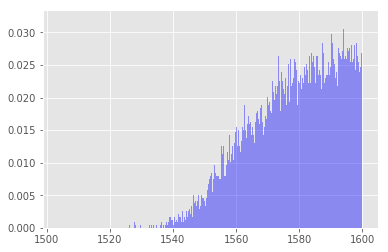

In [64]:
plt.hist(eigs_l[np.logical_and(eigs_l<1600, eigs_l>100)] ,2000,density=True,color='blue',alpha=0.4)
plt.show()

In [ ]:
n, b, pin, pout = 100.0, 8, 1, 1
# Now solve the equation for t and increasing z in iterative way
t0 = (np.random.random() + np.random.random()*1j) * 1E-3
eps = 1E-9
z0 = -20 + eps*1j
zmax = 20
dz = 0.1

z = z0
t = t0

allt, allz = [], []
a = 10
d = 0
print(2*np.sqrt(a)-d)
while np.real(z) < zmax:
    print('\r',eps,(np.real(z)/zmax)*100,'%',end='')
    t = mp.findroot(lambda x: adj_feq2(a,d,x,z), x0 = t,solver='muller') # important to use the "muller" solver
    allz.append(z)
    z += dz
    allt.append(t)
allz = np.array([np.real(zz) for zz in allz])
allt = np.array([tt.imag for tt in allt])
plt.plot(allz,-1/(np.pi)*allt)
tmax = np.max(-1/(np.pi)*allt)
plt.vlines(-2*np.sqrt(a)+d,ymin=0,ymax=tmax)
plt.vlines(2*np.sqrt(a)+d, ymin=0,ymax=tmax)

In [ ]:
n, b, pin, pout = 500.0, 2, 0.8, 0.2
import networkx as nx
eigs_l,eigs_a = [], []
for i in range(0,100):
    A = nx.to_numpy_array(nx.planted_partition_graph(b,int(n/b),pin,pout))
    L=np.diag(A.sum(axis=0))-A
    #eigs_a.append(scipy.linalg.eigvalsh(A))
    eigs_l.append(scipy.linalg.eigvalsh(L))
eigs_a = np.array(eigs_a).flatten()
eigs_l = np.array(eigs_l).flatten()

In [ ]:
n, b, pin, pout = 500.0, 2, 0.8, 0.2
for count,a in enumerate(np.linspace(250,300,5)):
    # Now solve the equation for t and increasing z in iterative way
    t0 = (np.random.random() + np.random.random()*1j) * 1E-3
    eps = 1E-9
    z0 = 1000.0 + eps*1j
    zmax = 1800
    dz = 5

    z = z0
    t = t0

    allt, allz = [], []
    #a = 1
    d = n/b*(pin+pout)
    while np.real(z) < zmax:
        print('\r',count,eps,(np.real(z)/zmax)*100,'%',end='')
        t = mp.findroot(lambda x: lapl_feq2(a,d,x,z), x0 = t,solver='muller') # important to use the "muller" solver
        allz.append(z)
        z += dz
        allt.append(t)
    allz = np.array([np.real(zz) for zz in allz])
    allt = np.array([tt.imag for tt in allt])
    plt.figure()
    plt.plot(allz,np.abs(-1/(np.pi)*allt))
    plt.hist(eigs_l,400,density=True,color='blue',alpha=0.4)
    plt.title('a=%1.1f'%a)
plt.show()